# Fake News Classification

## Introduction
The data from this analysis is from kaggle: [Fake and real news dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset), which contains two news data from different sources. One of the data contains real news and another file contains fake news.

The purpose of this analysis is to analyze the data using **Python NLTK tools** and **Sklearn kit** to perform basic natural language processing and machining learning methods to train the dataset to build a classifier to identify fake news from real ones.

The methods used in this analysis includes:

- Word tokenizing
- Stop words and punctuations removal
- Lexical dispersion plot
- Naive Bayes Classification
- logestic Regression

## Loading data

The analysis starts with loading data and necessary library.

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
import random
from string import punctuation
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize


from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score
%matplotlib inline

# Set default plot size
plt.rcParams["figure.figsize"] = (15,8)

The data contains the title of the news, the actual content of the news,which will be what I will focus on, the subject of the news and the date of the news. For the convenience of the analysis, I added one more column called **Authenticity** to differentiate fake news from real news. 

In [2]:
# Load and preview data 
fake = pd.read_csv("/Users/leo/Personal/GitHub/Fake_and_Real_News_Classifier/Fake.csv")
real = pd.read_csv("/Users/leo/Personal/GitHub/Fake_and_Real_News_Classifier/True.csv")
fake['Authenticity'] = 'Fake'
real['Authenticity'] = 'Real'
news_data = fake.append(real)
news_data.head()

,title,text,subject,date,Authenticity
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake


## Data Preprocessing and EDA

Before fit the data into a classifier, the text data needs to be preprocessed and explored.

First, we need to tokenize the text, and thenremove the stopwords and punctuation from the text.

In [3]:
sw = stopwords.words('english')

new_words=('’','“', '”')

for i in new_words:
    sw.append(i)


# Convert to lower case
news_data['text'] = news_data['text'].str.lower()

# Tokenizing
news_data['tokenized_text'] = news_data['text'].apply(word_tokenize)

# Remove stopwords
news_data['filtered_text'] = news_data['tokenized_text'].apply(lambda x: [item for item in x if item not in sw])

# Remove punction
news_data['filtered_text'] = news_data['filtered_text'].apply(lambda x: [item for item in x if item not in punctuation])

# Check results
print(len(news_data['text'].iloc[0]),
      len(news_data['tokenized_text'].iloc[0]),
      len(news_data['filtered_text'].iloc[0]))

2893 599 287


In [4]:
news_data.head()

,title,text,subject,date,Authenticity,tokenized_text,filtered_text
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",Fake,"[donald, trump, just, couldn, t, wish, all, am...","[donald, trump, wish, americans, happy, new, y..."
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",Fake,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"on friday, it was revealed that former milwauk...",News,"December 30, 2017",Fake,"[on, friday, ,, it, was, revealed, that, forme...","[friday, revealed, former, milwaukee, sheriff,..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"on christmas day, donald trump announced that ...",News,"December 29, 2017",Fake,"[on, christmas, day, ,, donald, trump, announc...","[christmas, day, donald, trump, announced, wou..."
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",Fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, annual, christmas, day, ..."


Then create a simple wordcloud from the dataset.

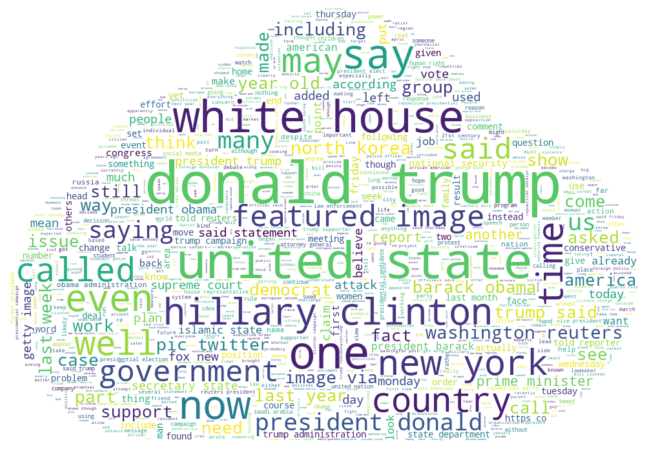

In [5]:
text = " ".join(text for text in news_data.text)

mask = np.array(Image.open("/Users/leo/Personal/GitHub/Fake_and_Real_News_Classifier/Mask.png"))

wordcloud = WordCloud(background_color="white", max_words=1000, mask=mask,
                      max_font_size=90, random_state=42).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


The I create two separate datasets for fake and real news to examine the most commonly appeared words in each dataset using `FreqDist` function from `nltk`.

In [6]:
news_data_fake = news_data[news_data.Authenticity == 'Fake']
news_data_real = news_data[news_data.Authenticity == 'Real']

news_data_fake.head()

,title,text,subject,date,Authenticity,tokenized_text,filtered_text
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",Fake,"[donald, trump, just, couldn, t, wish, all, am...","[donald, trump, wish, americans, happy, new, y..."
1,Drunk Bragging Trump Staffer Started Russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",Fake,"[house, intelligence, committee, chairman, dev...","[house, intelligence, committee, chairman, dev..."
2,Sheriff David Clarke Becomes An Internet Joke...,"on friday, it was revealed that former milwauk...",News,"December 30, 2017",Fake,"[on, friday, ,, it, was, revealed, that, forme...","[friday, revealed, former, milwaukee, sheriff,..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"on christmas day, donald trump announced that ...",News,"December 29, 2017",Fake,"[on, christmas, day, ,, donald, trump, announc...","[christmas, day, donald, trump, announced, wou..."
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",Fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, used, annual, christmas, day, ..."


In [7]:
fake = news_data_fake.filtered_text.tolist()

fake_list = []
for sublist in fake:
    for item in sublist:
        fake_list.append(item)

real = news_data_real.filtered_text.tolist()

real_list = []
for sublist in real:
    for item in sublist:
        real_list.append(item)
        
all_words = news_data.filtered_text.tolist()

all_words_list = []
for sublist in all_words:
    for item in sublist:
        all_words_list.append(item)

Using `most_common()` function from `nltk`, this will print out the most commonly appeared words  in fake, real and all news datasets. As we can see that there are some overlaps in most common words.

In [8]:
vocab_fake = nltk.FreqDist(fake_list)
vocab_real = nltk.FreqDist(real_list)
vocab_all = nltk.FreqDist(all_words_list)

print('Fake most common words: ',vocab_fake.most_common(20),
     'Real most common words: ',vocab_real.most_common(20),
     'All most common words: ',vocab_real.most_common(20))

Fake most common words:  [('trump', 74233), ('said', 31145), ('people', 26011), ('president', 25739), ('would', 23461), ('one', 22992), ('clinton', 18079), ('obama', 17919), ('like', 17660), ('donald', 17234), ('also', 15242), ('new', 14198), ('news', 14195), ('us', 13917), ('even', 13690), ('hillary', 13673), ('white', 12797), ('time', 12790), ('state', 12543), ('via', 11353)] Real most common words:  [('said', 99035), ('trump', 54248), ('u.s.', 38460), ('would', 31526), ('reuters', 28410), ('president', 26397), ('state', 19728), ('government', 18287), ('new', 16784), ('house', 16519), ('states', 16513), ('also', 15946), ('united', 15576), ('republican', 15344), ('people', 15138), ('told', 14244), ('could', 13707), ('one', 12675), ('last', 12613), ('party', 12436)] All most common words:  [('said', 99035), ('trump', 54248), ('u.s.', 38460), ('would', 31526), ('reuters', 28410), ('president', 26397), ('state', 19728), ('government', 18287), ('new', 16784), ('house', 16519), ('states', 

To further analyze the distribution of the most common words, I choose the top most common words from fake and real news dataset and plot the Lexical **Dispersion Plot**. I'm only choosing the first 10000 character from each datasets.

As we can see, the first plot is the fake news and the second plot is the real news. The word **said** has appeared more frequently and condensed in the real news datasets then the fake news datasets.

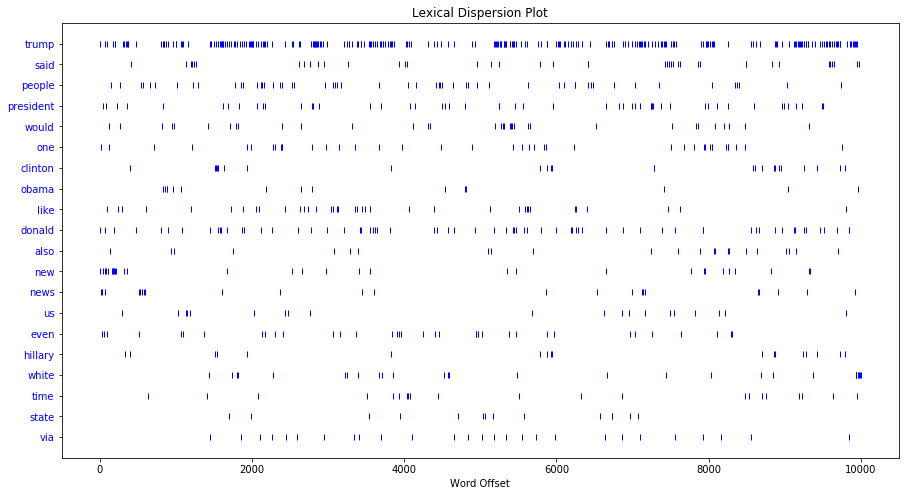

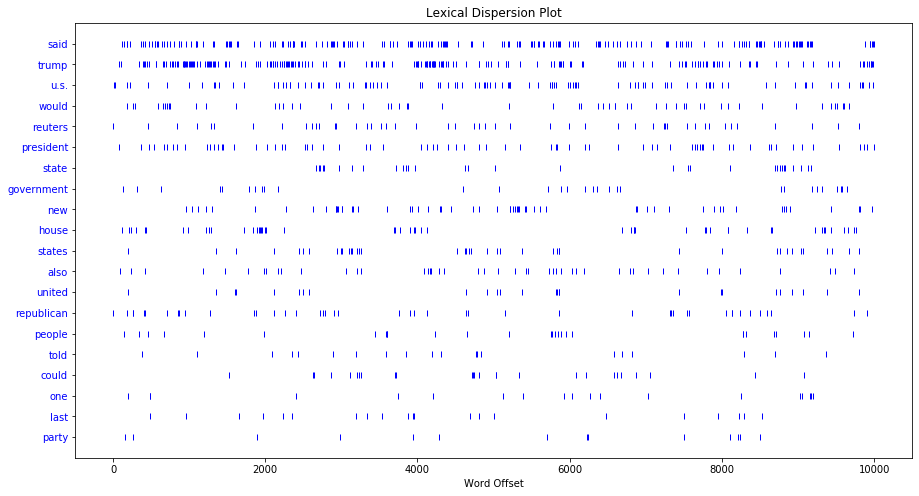

In [9]:
common_words_fake = [item[0] for item in vocab_fake.most_common(20)]
nltk.Text(fake_list[:10000]).dispersion_plot(common_words_fake)

common_words_real = [item[0] for item in vocab_real.most_common(20)]
nltk.Text(real_list[:10000]).dispersion_plot(common_words_real)

In [10]:
authenticity = []
for i in range(len(news_data)):
    authenticity.append((news_data['filtered_text'].iloc[i],news_data['Authenticity'].iloc[i]))
news_data['filtered_text_authenticity'] = authenticity

## Classification

After exploring the data, we had a better understanding of the dataset. We can start building our classifier to train our datasets.

For this part, I'm using `TfidfVectorizer` module from `sklearn.feature_extraction.text`, The result is a sparse matrix recording the number of times each word appears and weights the word counts by a measure of how often they appear in the documents. The result can then be fit to a multinomial Naive Bayes classifier.

In [11]:
vectorizer = TfidfVectorizer(stop_words=sw,lowercase=True)
y = news_data.Authenticity
x = vectorizer.fit_transform(news_data.text)

In [12]:
print (x.shape)
print (y.shape)

(44898, 121858)
(44898,)


In [13]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

After we train the model, we want to test how accurate the model is. By using the `confusion_matrix`, we can plot a `heatmap` using `seaborn` to see how much records in the testing data the classifier has been successfully predicted.

From the plot, we can see that the result is pretty good.

Text(315.06, 0.5, 'predicted label')

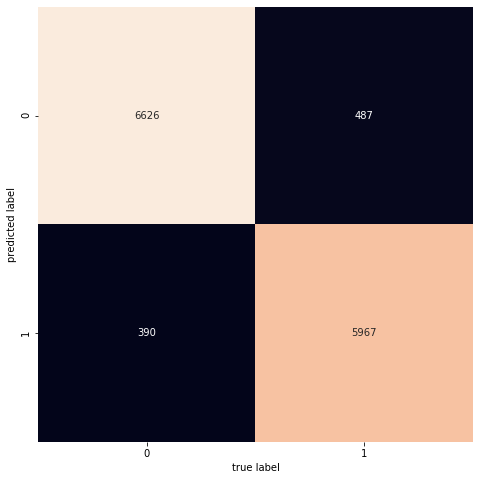

In [14]:
labels = NB_classifier.predict(X_test)

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

The roc auc score shows 98% accuracy, which means it's a very good model.

In [15]:
roc_auc_score(y_test,NB_classifier.predict_proba(X_test)[:,1])

0.9799494996429429

By printing out `classification_report`, we can see that both fake and real news have a 94% precision.

In [16]:
print(classification_report(y_test,labels))

              precision    recall  f1-score   support

        Fake       0.93      0.94      0.94      7016
        Real       0.94      0.92      0.93      6454

    accuracy                           0.93     13470
   macro avg       0.94      0.93      0.93     13470
weighted avg       0.93      0.93      0.93     13470



After training the dataset to a Naive Bayes classifier, I also want to see how logestic regression model fits the data. Follwoing the similiar procedures, I train the data using logestic regression.

In [17]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The model score is 0.98, which means logestic regression model also fits pretty well.

In [18]:
model.score(X_test, y_test)

0.9856718634001485

Similiarly, the confusion matrix heatmap and the classification report also indicate that logestic regression model fits the data well.

Comparing the two classifiers, we can see that the **logestic regression model** actually doing a better job than Naive Bayes in classifying this dataset as it makes more accurate predictions.

Text(315.06, 0.5, 'true value')

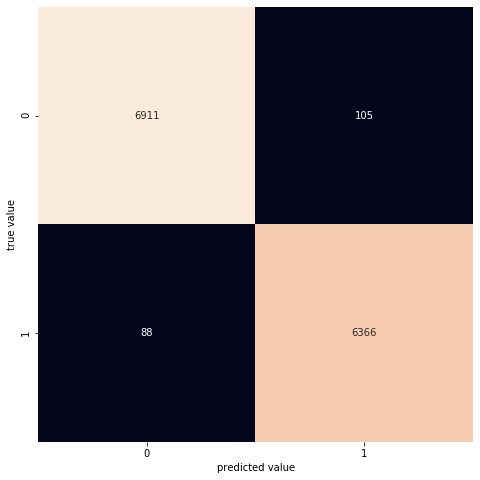

In [19]:
y_model = model.predict(X_test)

mat = confusion_matrix(y_test,y_model)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False) 
plt.xlabel('predicted value')
plt.ylabel('true value')

In [20]:
print(classification_report(y_test,y_model))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      7016
        Real       0.98      0.99      0.99      6454

    accuracy                           0.99     13470
   macro avg       0.99      0.99      0.99     13470
weighted avg       0.99      0.99      0.99     13470

